# Replication: Mak et al., 2017

This notebook attempts to replicate the following paper, using the [PPMI](http://ppmi-info.org/) dataset:

<div class="alert alert-block alert-success">
   	E. Mak et al., <a href="https://www.sciencedirect.com/science/article/pii/S0197458017300830"> “Longitudinal whole-brain atrophy and ventricular enlargement in nondemented Parkinson’s disease”</a>, Neurobiology of aging, vol. 55, pp. 78–90, 2017.
</div>

This study included PD subjects ($n=104$) and healthy controls ($n=38$) who completed a baseline and and follow-up T1 MRI at 18 months.
The demographic of the studied population was as follow (table extracted from the paper).

<div><img src="figures/table1.png" width="1200px"></div>


In [1]:
# TODO
# - Brief summary of image analysis to be reproduced
# - Key results to be reproduced


In [2]:
import os

import livingpark_utils

os.environ["PIP_REQUIRE_VIRTUALENV"] = "False"
utils = livingpark_utils.LivingParkUtils()
utils.notebook_init()


This notebook was run on 2023-06-21 02:19:53 UTC +0000


# PPMI Metadata Download

We download metadata file from the PPMI database, using [`ppmi-downloader`](https://pypi.org/project/ppmi-downloader/) available on PyPi.
</br>Your PPMI credentials will be asked before download.


In [3]:
from livingpark_utils.download import ppmi

ppmi_downloader = ppmi.Downloader(utils.study_files_dir)

required_files = [
    "Demographics.csv",
    "Age_at_visit.csv",
    "MDS-UPDRS_Part_III.csv",
    "Socio-Economics.csv",
    "Montreal_Cognitive_Assessment__MoCA_.csv",
    "PD_Diagnosis_History.csv",
    "Cognitive_Categorization.csv",
    "Participant_Status.csv",
    "LEDD_Concomitant_Medication_Log.csv",
    "Pilot_Biospecimen_Analysis_Results.csv",
]

utils.get_study_files(required_files, default=ppmi_downloader)


Download skipped: No missing files!


## Download LivingPark utility notebook

Here below, we download and execute utility notebook from the LivingPark project.
</br>These notebook will create cleaned up metadate file needed throughout this notebook.


In [4]:
%%capture
from livingpark_utils.scripts import (
    mri_metadata,
    pd_status,
)

# Cohort Matching


In [5]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.figsize"] = (16, 8)


In [6]:
from livingpark_utils.dataset import ppmi
from livingpark_utils.visualization import reformat_plot_labels


## Data preparation


### Cohort Definition


[Text(0, 0, 'PD'), Text(1, 0, 'HC')]

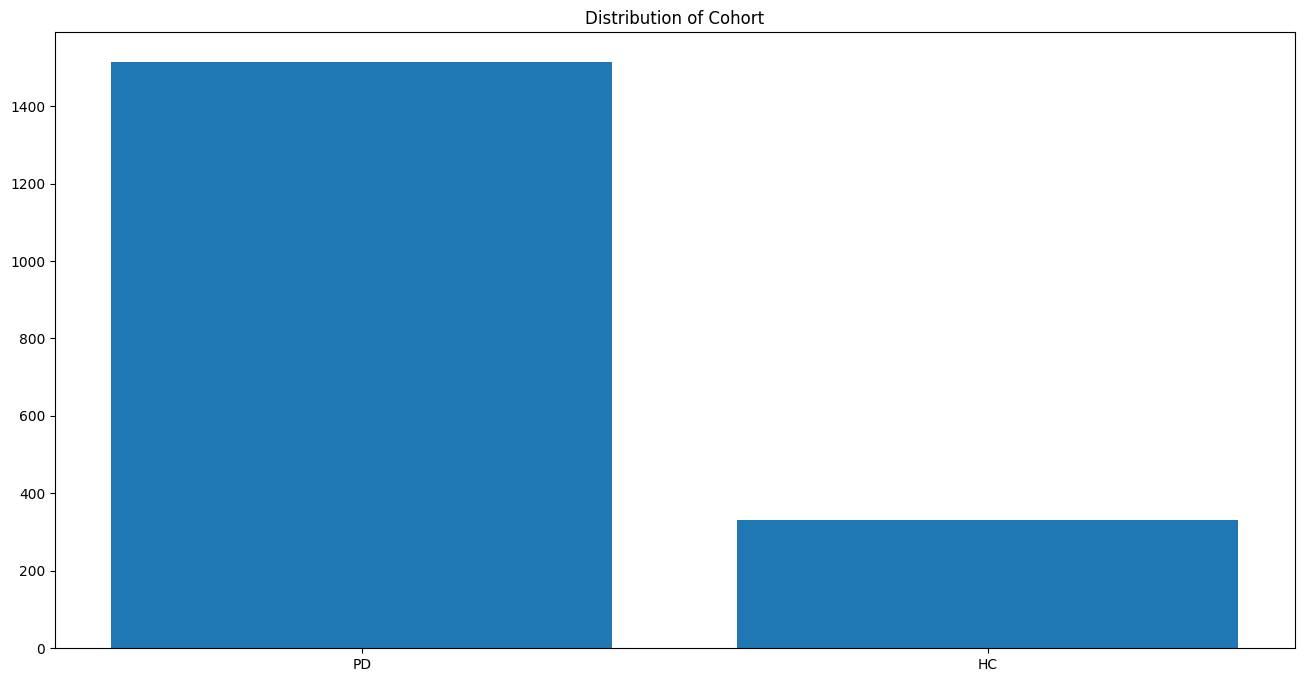

In [7]:
cohort_def = pd.read_csv(os.path.join(utils.study_files_dir, "Participant_Status.csv"))[
    ["PATNO", "COHORT"]
]
cohort_def = cohort_def[cohort_def["COHORT"].isin([1, 2])]  # Only keep PD and HC.

fig, ax = plt.subplots()
dist = cohort_def.groupby(["COHORT"]).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of Cohort")

reformat_plot_labels(dist, ax, 1)
ax.set_xticklabels(["PD", "HC"])


### Cognitive state


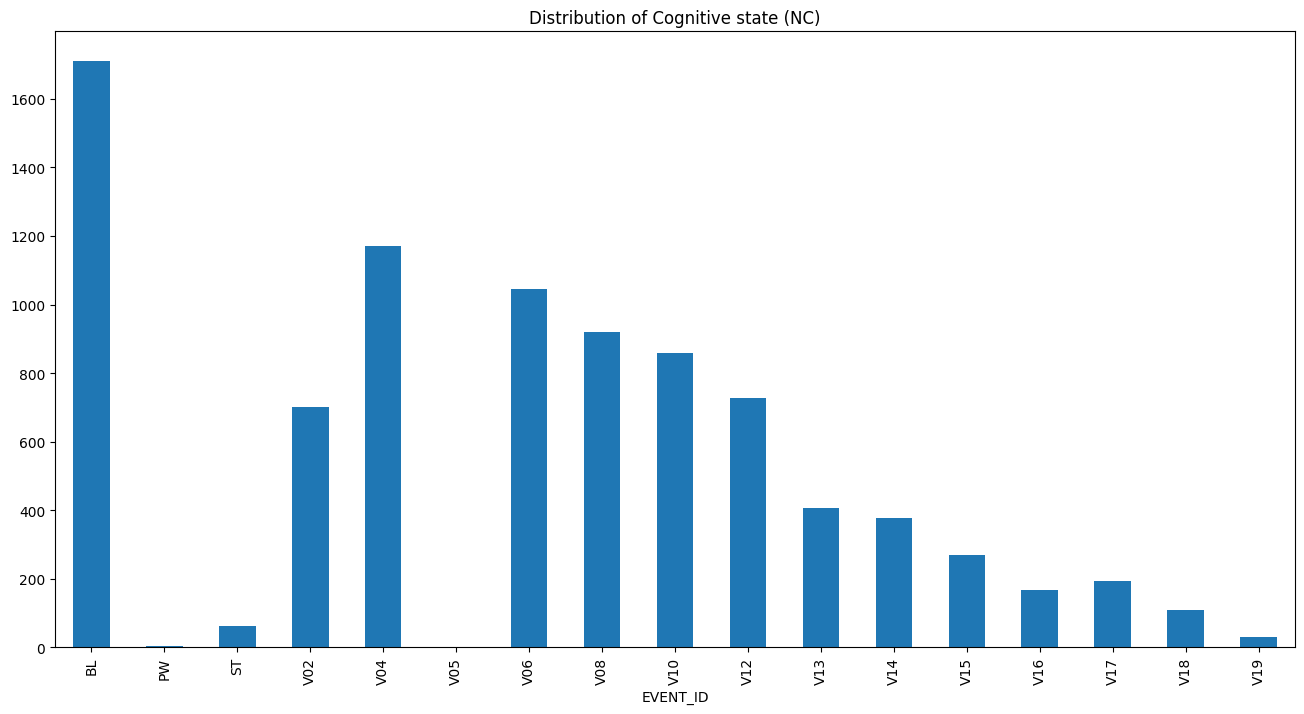

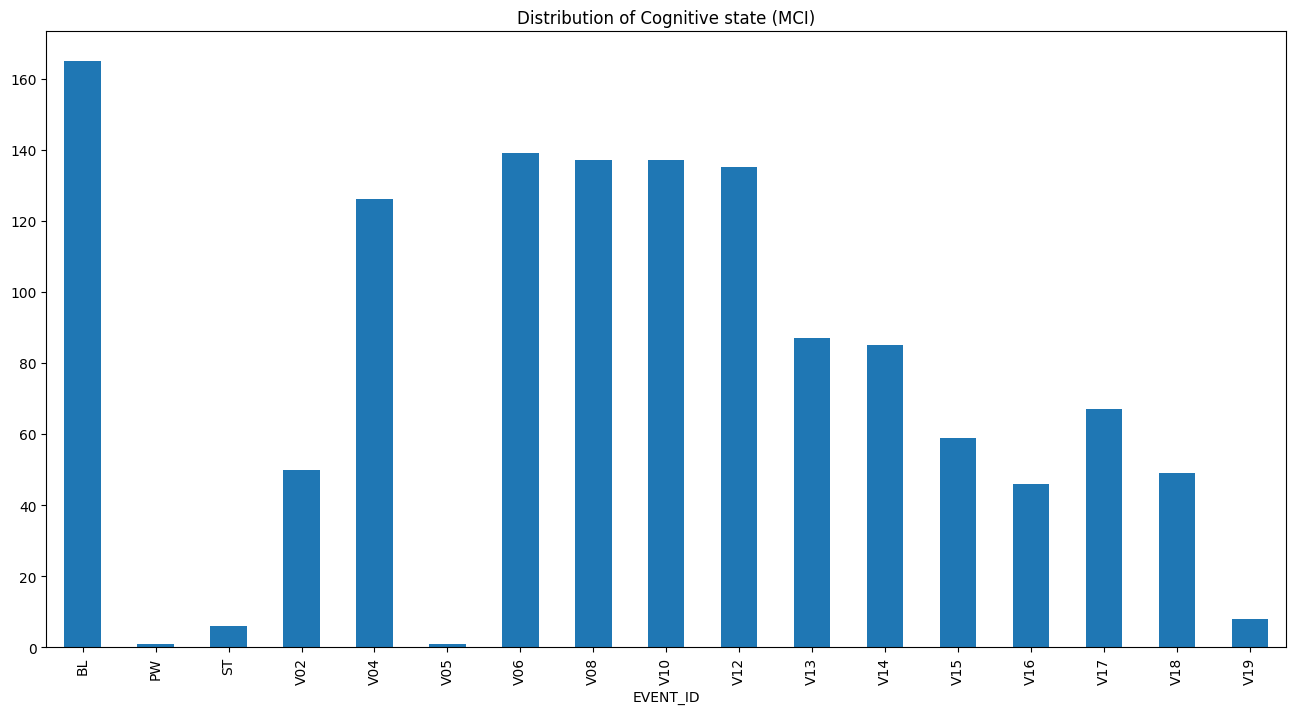

In [8]:
cog_state = pd.read_csv(
    os.path.join(utils.study_files_dir, "Cognitive_Categorization.csv")
)[["PATNO", "EVENT_ID", "COGSTATE"]]
cog_state = cog_state[cog_state["COGSTATE"] != 3]  # Drop all cases of PDD

cog_state_dist = (
    cog_state.groupby(["COGSTATE", "EVENT_ID"])["PATNO"]
    .nunique()
    .rename({1: "NC", 2: "MCI"})
)
shared_index = np.intersect1d(cog_state_dist["NC"].index, cog_state_dist["MCI"].index)
cog_state_dist["NC"][shared_index].plot.bar(
    title="Distribution of Cognitive state (NC)"
)
plt.show()
cog_state_dist["MCI"][shared_index].plot.bar(
    title="Distribution of Cognitive state (MCI)"
)
plt.show()


We observe that NC subjects account for a majority of the PPMI cohort.
</br>Therefore, in our following steps, we will focus on obtaining MCI subjects before NC ones.


### Diseases duration


In [9]:
pdxdur = ppmi.disease_duration(utils.study_files_dir)


Download skipped: No missing files!


### MRI availability


In [10]:
mri = pd.read_csv(os.path.join(utils.study_files_dir, "MRI_info.csv"))
mri["EVENT_ID"] = mri["Visit code"]
mri["PATNO"] = mri["Subject ID"]
mri["Sex"] = mri["Sex"].map({"F": 0, "M": 1})
mri = mri.drop(["Subject ID", "Visit code", "Visit", "Age", "Sex"], axis=1)
mri.groupby("EVENT_ID").size().sort_values(ascending=False).head(5)


EVENT_ID
BL     2114
V10     457
V04     398
V06     342
ST       10
dtype: int64

The only visits with enough MRI available to replicate the study are: BL (baseline), V04, V06, and V10. Therefore we will only consider these visits.


### Examination scores


#### Hoehn and Yahr (H&Y)


Text(0.5, 1.0, 'Distribution of H&Y scores')

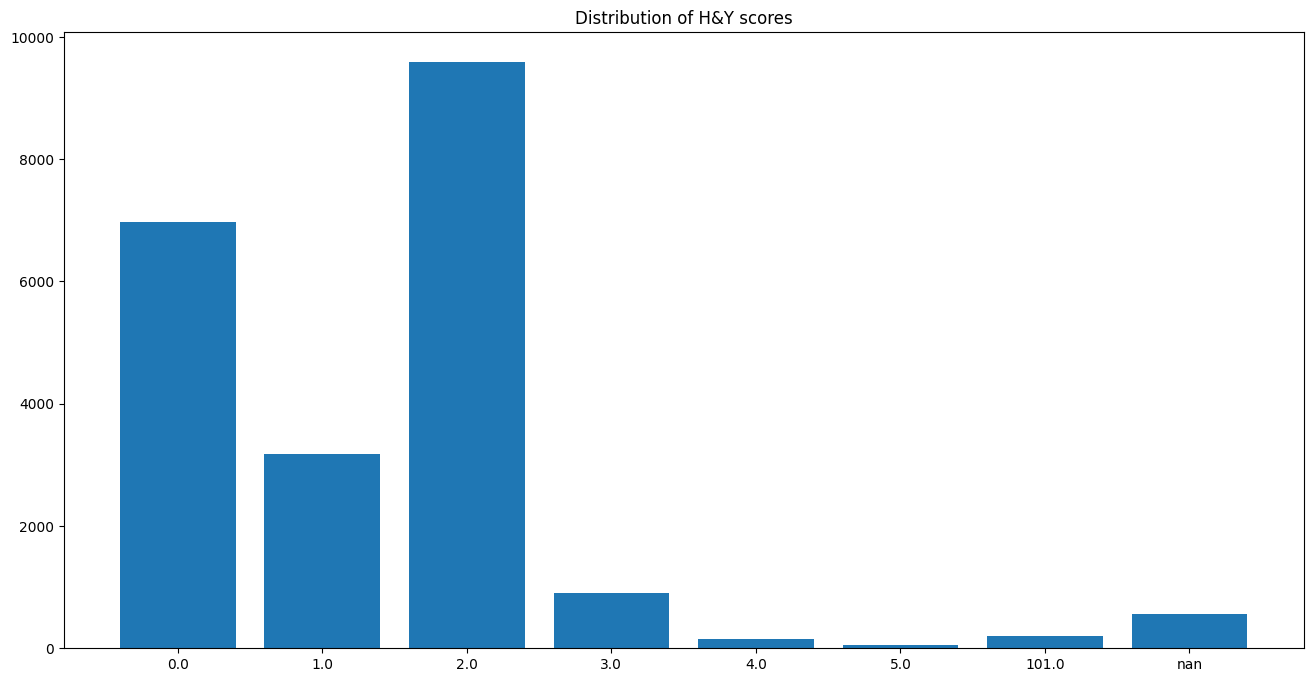

In [11]:
updrs3 = pd.read_csv(
    os.path.join(utils.study_files_dir, "MDS_UPDRS_Part_III_clean.csv")
)[["PATNO", "EVENT_ID", "PDSTATE", "PDTRTMNT", "NP3TOT", "NHY"]]
dist = updrs3.groupby(["NHY"], dropna=False).size()

plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of H&Y scores")


We remove the subjects which clinicians were unable to rate the H&Y score (UR)


In [12]:
updrs3 = updrs3[updrs3["NHY"] != "UR"]
updrs3["NHY"] = pd.to_numeric(updrs3["NHY"])


#### Unified Parkinso's Disease Rating Scale, Part III (UDPRS III)


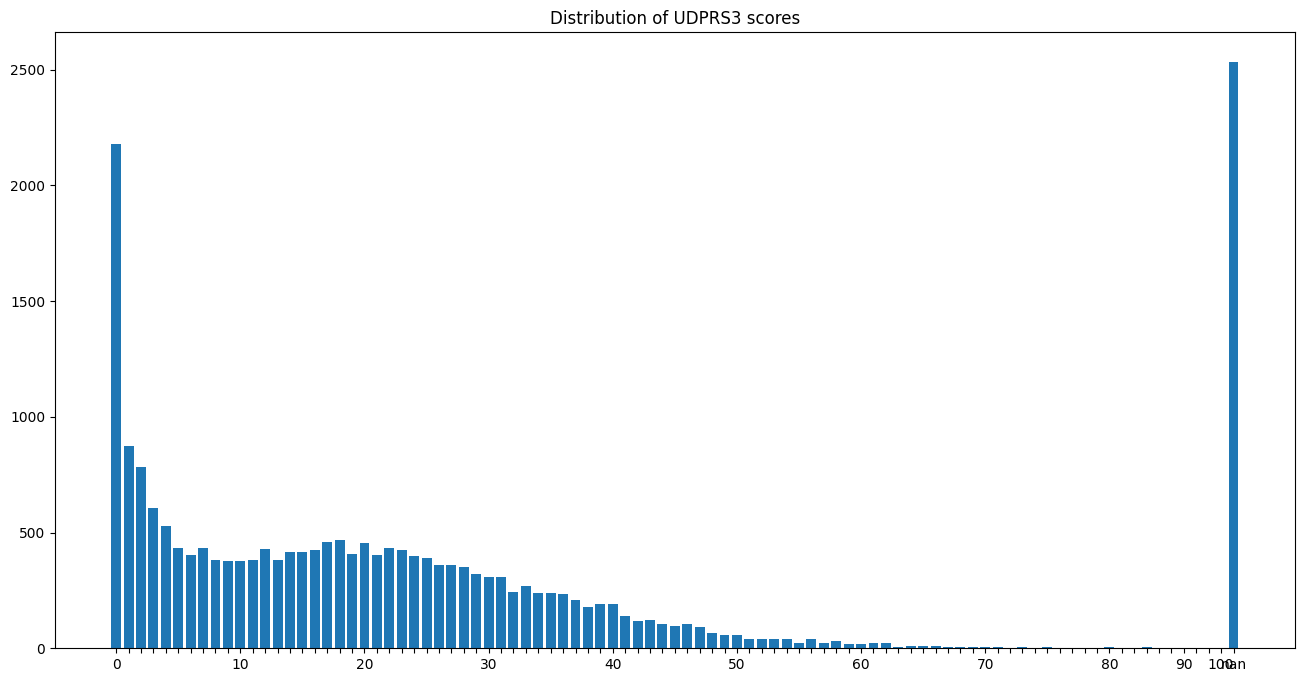

In [13]:
fig, ax = plt.subplots()
dist = updrs3.groupby(["NP3TOT"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of UDPRS3 scores")

reformat_plot_labels(dist, ax, 10)


#### Montreal Cognitive Assessment (MoCA)

Due to the low amount of MRI availability at baseline, we consider the MoCA scores at screening as substitute for baseline.


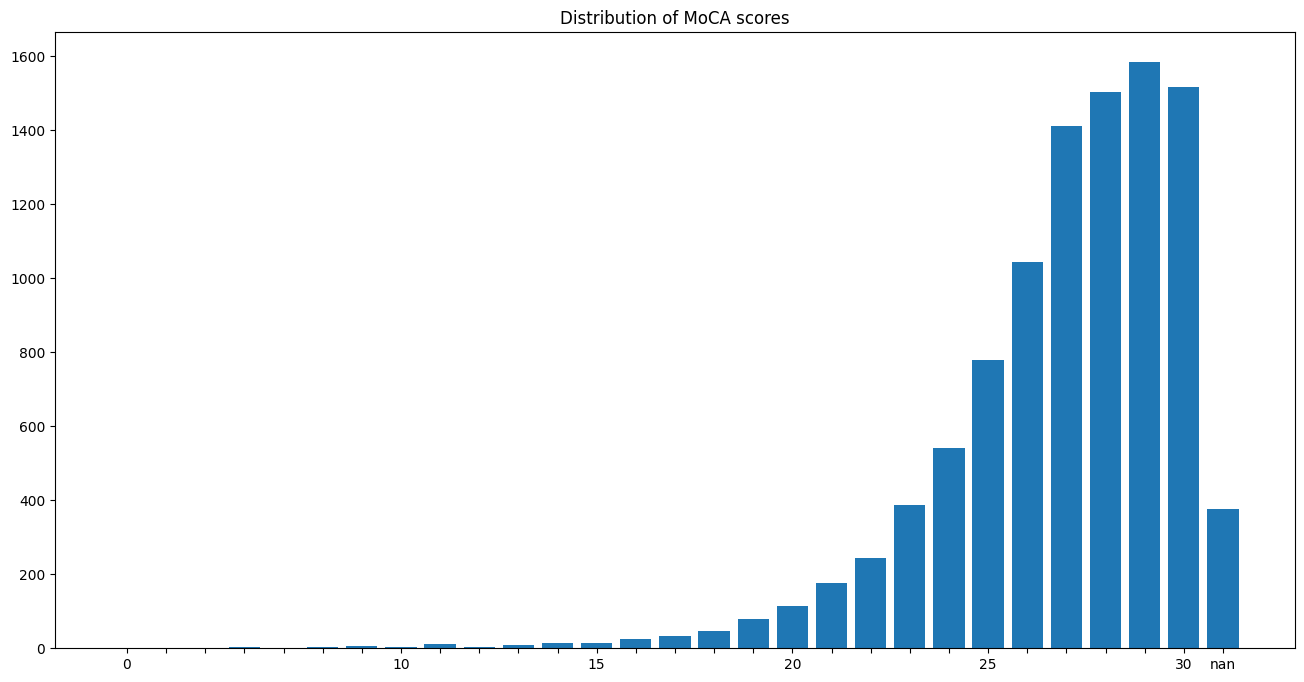

In [14]:
moca = pd.read_csv(
    os.path.join(utils.study_files_dir, "Montreal_Cognitive_Assessment__MoCA_.csv")
)[["PATNO", "EVENT_ID", "MCATOT"]]

# Use screening instead of baseline.
moca = moca[moca["EVENT_ID"] != "BL"]
moca["EVENT_ID"].mask(moca["EVENT_ID"] == "SC", "BL", inplace=True)

fig, ax = plt.subplots()
dist = moca.groupby(["MCATOT"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of MoCA scores")

reformat_plot_labels(dist, ax, 5)


0.0


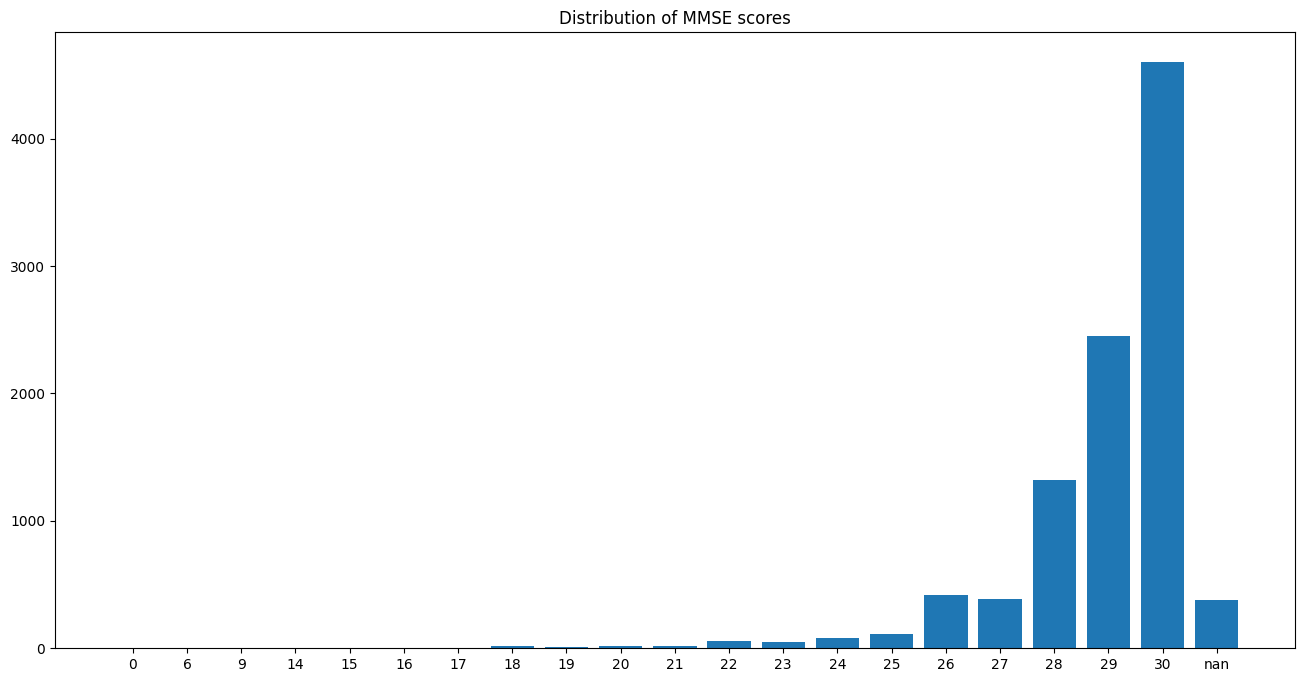

In [15]:
from livingpark_utils.clinical import moca2mmse

moca["MMSETOT"] = moca["MCATOT"].apply(moca2mmse)

fig, ax = plt.subplots()
dist = moca.groupby(["MMSETOT"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of MMSE scores")

reformat_plot_labels(dist, ax, 1)


#### LEDD (mg/d) baseline


In [16]:
mri_info = pd.read_csv(os.path.join(utils.study_files_dir, "3D_mri_info.csv")).rename(
    columns={"Subject ID": "PATNO", "Visit": "EVENT_ID"}
)[["PATNO", "EVENT_ID", "Study Date"]]

mri_info["EVENT_ID"] = mri_info["EVENT_ID"].map(
    {
        "Screening": "SC",
        "Baseline": "BL",
        "Month 6": "V02",
        "Month 12": "V04",
        "Month 24": "V06",
        "Month 36": "V08",
        "Month 48": "V10",
    }
)
mri_info["Study Date"] = pd.to_datetime(mri_info["Study Date"])


<Axes: title={'center': 'Distribution of daily LEDD dosage'}, ylabel='Frequency'>

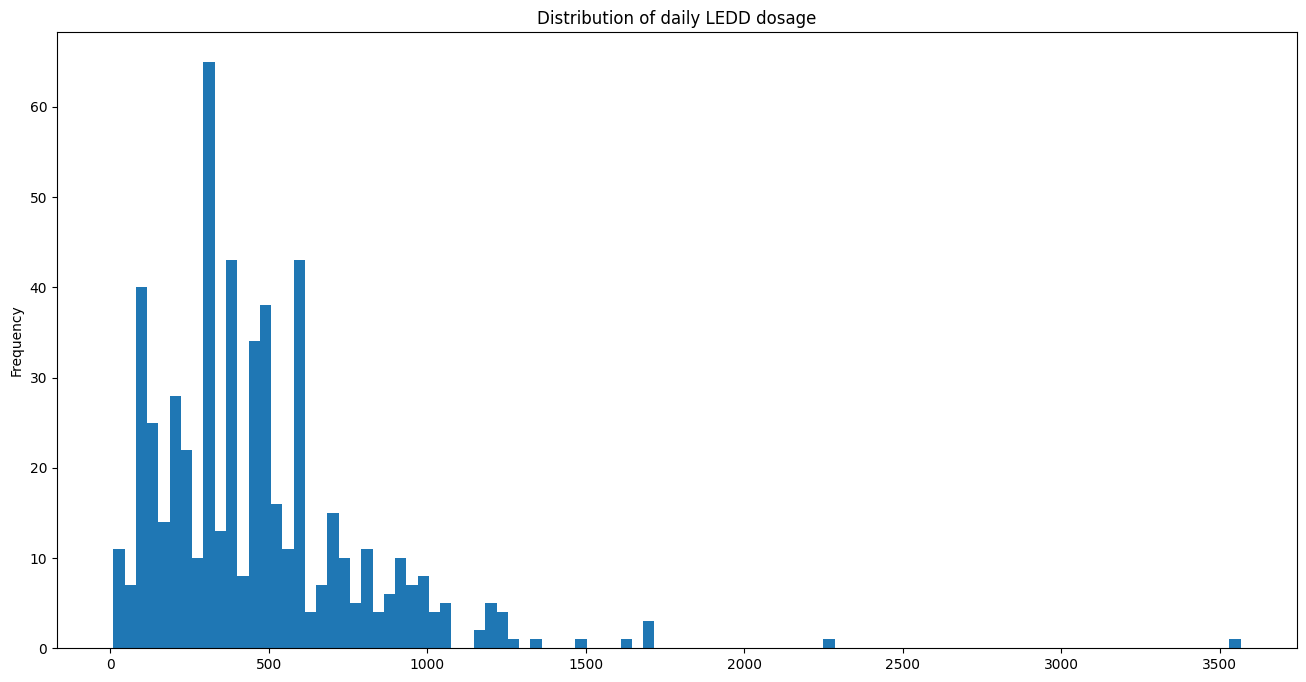

In [17]:
ledd = pd.read_csv(
    os.path.join(utils.study_files_dir, "LEDD_Concomitant_Medication_Log.csv")
).drop("EVENT_ID", axis=1)

ledd["STARTDT"] = pd.to_datetime(ledd["STARTDT"])
ledd["STOPDT"] = pd.to_datetime(ledd["STOPDT"])
ledd["STOPDT"] = ledd["STOPDT"].mask(
    ledd["STOPDT"].isna(), np.datetime64("now")
)  # Include in progress dates.

ledd["PATNO"] = ledd["PATNO"].astype(str)

ledd = ledd[~ledd["LEDD"].isin(["LD x 0.33", "LD x 0.5"])]
ledd["LEDD"] = ledd["LEDD"].astype(np.float16)

visit_ledd = ledd.merge(mri_info, on=["PATNO"])
ledd_clean = visit_ledd[
    (visit_ledd["STARTDT"] <= visit_ledd["Study Date"])
    & (visit_ledd["Study Date"] <= visit_ledd["STOPDT"])
].drop_duplicates()
ledd = (
    ledd_clean[ledd_clean["LEDD"].notna()]
    .groupby(["PATNO", "EVENT_ID"])["LEDD"]
    .sum()
    .to_frame()
    .reset_index()
)
ledd["PATNO"] = ledd["PATNO"].astype(np.int64)

ledd["LEDD"].plot(kind="hist", title="Distribution of daily LEDD dosage", bins=100)


### Demographics


#### Sex


In [18]:
demo = pd.read_csv(os.path.join(utils.study_files_dir, "Demographics.csv"))[
    ["PATNO", "SEX"]
]
demo["SEX"] = demo["SEX"].astype(int)
print("Distribution of Sex")
demo.groupby("SEX").size().rename({0: "Female", 1: "Male"})


Distribution of Sex


SEX
Female    1294
Male      1755
dtype: int64

#### Age at visit

We consider the age at specific visits. However for simplicity, we only plot the age distribution at baseline.


<Axes: title={'center': 'Distribution of Age at Baseline'}, ylabel='Frequency'>

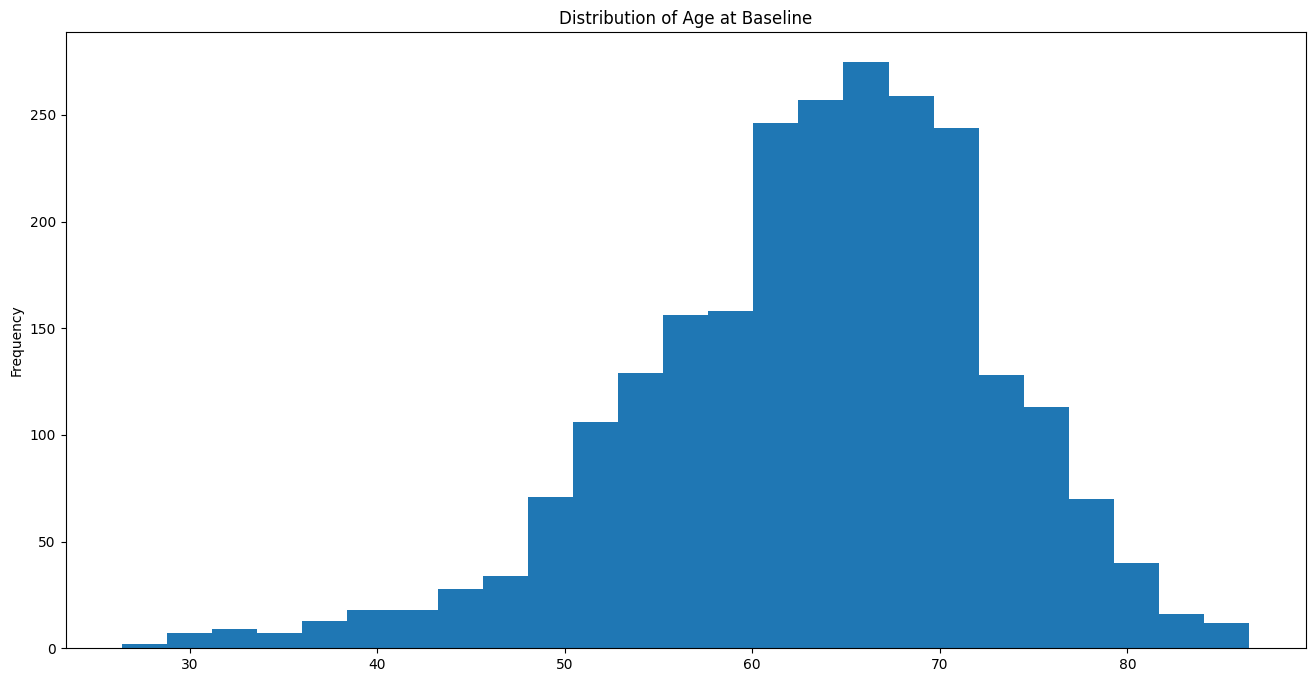

In [19]:
age = pd.read_csv(os.path.join(utils.study_files_dir, "Age_at_visit.csv"))[
    ["PATNO", "EVENT_ID", "AGE_AT_VISIT"]
]

age[age["EVENT_ID"] == "BL"]["AGE_AT_VISIT"].plot.hist(
    bins=25, title="Distribution of Age at Baseline"
)


#### Education


We only use the education years at screening since most of the other visits do not have records of it and most likely did not change.
</br>Moreover, when present, the education years at further visits showed incositency limiting the possibility to perform data imputation.


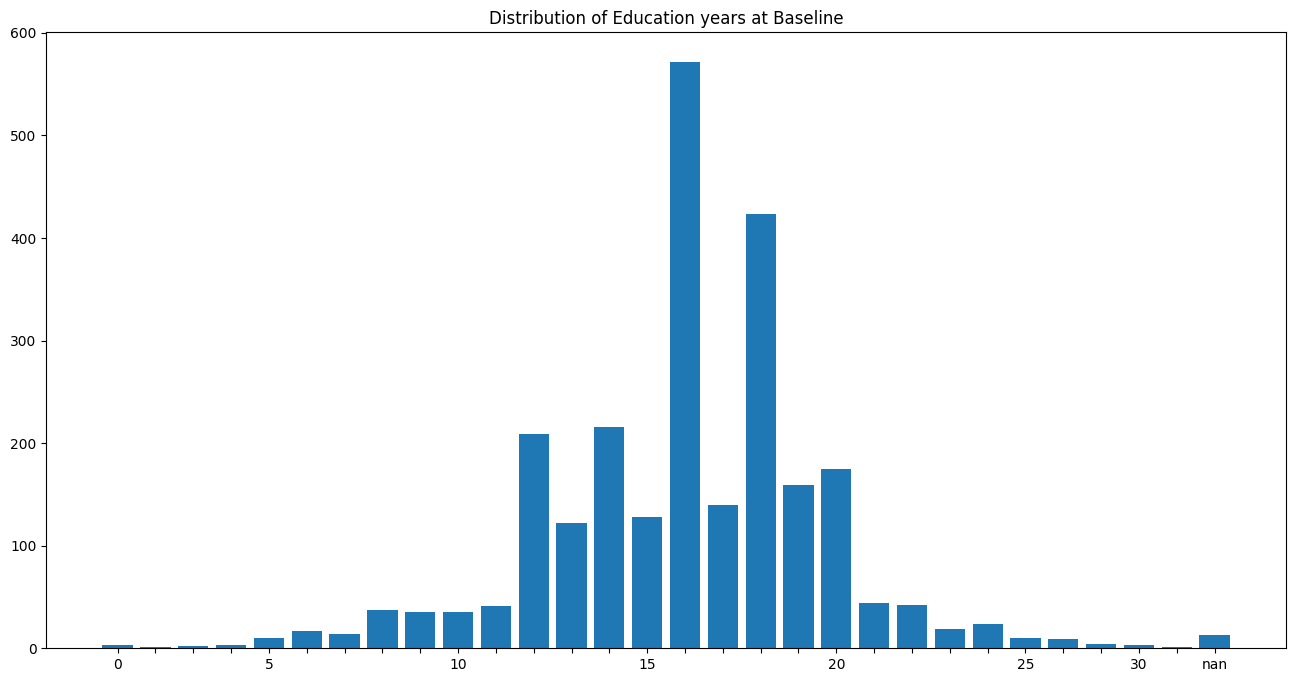

In [20]:
socio = pd.read_csv(os.path.join(utils.study_files_dir, "Socio-Economics.csv"))[
    ["PATNO", "EVENT_ID", "EDUCYRS"]
]

socio = socio[socio["EVENT_ID"] == "SC"]
socio = socio.drop(["EVENT_ID"], axis=1)


fig, ax = plt.subplots()
dist = socio.groupby(["EDUCYRS"], dropna=False).size()
plt.bar(dist.index.astype(str), dist.values)
plt.title("Distribution of Education years at Baseline")

reformat_plot_labels(dist, ax, 5)


## Patient exclusion

Some patient failed the preprocessing steps. We therefore exclude from our cohort definition.


In [21]:
from livingpark_utils.ignore import (
    insert_hash,
    remove_ignored,
)

mri = insert_hash(mri, columns=["PATNO", "EVENT_ID", "Description"])
mri = remove_ignored(
    mri,
    ignore_file=".ppmiignore",
)


## Data aggregation

We merge the data ingested above to obtain a set of data with available

- MRI image
- Disease duration
- Cognitive and PD State
- UPDRS III, MoCA, and MMSE scores
- Socio-economic and demographic data


In [22]:
keys = ["PATNO", "EVENT_ID"]
pd_df = (
    mri.merge(cohort_def[cohort_def["COHORT"] == 1])
    .merge(cog_state, on=keys)
    .merge(age, on=keys)
    .merge(demo, on=["PATNO"])
    .merge(socio, on=["PATNO"])
    .merge(updrs3, on=keys)
    .merge(moca, on=keys)
    .merge(pdxdur, on=keys)
    .merge(ledd, on=keys)
    .drop_duplicates()
    .groupby("PATNO")
    .filter(lambda g: g["EVENT_ID"].nunique() > 1)
)

hc_df = (
    mri.merge(cohort_def[cohort_def["COHORT"] == 2])
    .merge(age, on=keys)
    .merge(demo, on=["PATNO"])
    .merge(socio, on=["PATNO"])
    .merge(moca, on=keys)
    .drop_duplicates()
)


In [23]:
nc_patno = pd_df[pd_df["COGSTATE"] == 1]["PATNO"]
mci_patno = pd_df[pd_df["COGSTATE"] == 2]["PATNO"]


<div class="alert alert-block alert-warning">
    <span style="font-weight: bold">Note:</span> Patients can transition from NC to MCI between visits.
</div>


In [24]:
print(f"Unique number of HC patients: {hc_df['PATNO'].nunique()}")
print(f"Unique number of NC patients: {nc_patno.nunique()}")
print(f"Unique number of MCI patients: {mci_patno.nunique()}")

pd_df.groupby(["COGSTATE", "EVENT_ID"])["PATNO"].nunique().rename({1: "NC", 2: "MCI"})


Unique number of HC patients: 212
Unique number of NC patients: 111
Unique number of MCI patients: 33


COGSTATE  EVENT_ID
NC        BL          19
          V04         61
          V06         92
          V10         78
MCI       BL           2
          V04         10
          V06         19
          V10         20
Name: PATNO, dtype: int64

<div class="alert alert-block alert-danger">
    <span style="font-weight: bold">Issue:</span> At any visit, the amount of patients with MCI is lower than in the initial study (27).
</div>


## Find acceptable visit pairs

The inital study assess subjects at baseline and a follow-up visit at 18 month.
</br>Here below, we find the pairs of visits with the largest amount of MCI subject.


In [25]:
from livingpark_utils.maketal.maketal import find_acceptable_visit_pairs

find_acceptable_visit_pairs(pd_df, hc_df)


Unique PD-MCI subjects per visit pairs:
BL  & V06 =   2 | Month difference:                 24
BL  & V10 =   1 | Month difference:                 48
V04 & V06 =   9 | Month difference:                 12
V04 & V10 =   7 | Month difference:                 36
V06 & V10 =  14 | Month difference:                 24

Unique PD-NC subjects per visit pairs:
BL  & V04 =   5 | Month difference:                 12
BL  & V06 =  15 | Month difference:                 24
BL  & V10 =  10 | Month difference:                 48
V04 & V06 =  55 | Month difference:                 12
V04 & V10 =  48 | Month difference:                 36
V06 & V10 =  74 | Month difference:                 24

Unique HC subjects per visit pairs:
BL  & V04 =  55 | Month difference:                 12
BL  & V06 =   9 | Month difference:                 24
BL  & V08 =   2 | Month difference:                 36
BL  & V10 =  12 | Month difference:                 48
V04 & V06 =   8 | Month difference:                 12
V04

The pairs of visit with 12 or 24 months of interval have the most amount of MCI patients.
</br>We will explore the possibility of using those time interval for our replication cohort.


## Cohort with follow-up after 12 months


In [26]:
from livingpark_utils.maketal.maketal import create_cohort

mci, nc, hc = create_cohort(pd_df=pd_df, hc_df=hc_df, months=12)

print(
    f"""Unique number of:
  - HC subjects:     {hc['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {nc['PATNO'].unique().size} (/64)
  - PD-MCI subjects: {mci['PATNO'].unique().size} (/36)
"""
)


Unique number of:
  - HC subjects:     37 (/37)
  - PD-NC subjects:  56 (/64)
  - PD-MCI subjects: 9 (/36)



<div class="alert alert-block alert-danger">
    <span style="font-weight: bold">Issue:</span> With a follow-up after 12 months, the replication cohort is missing both PD-MCI patients.
</div>


## Cohort with follow-up after 24 months


In [27]:
mci_, nc_, hc_ = create_cohort(pd_df=pd_df, hc_df=hc_df, months=24)

print(
    f"""Unique number of:
  - HC subjects:     {hc_['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {nc_['PATNO'].unique().size} (/64)
  - PD-MCI subjects: {mci_['PATNO'].unique().size} (/36)
"""
)


Unique number of:
  - HC subjects:     9 (/37)
  - PD-NC subjects:  64 (/64)
  - PD-MCI subjects: 16 (/36)



<div class="alert alert-block alert-danger">
    <span style="font-weight: bold">Issue:</span> With a follow-up after 24 months, the replication cohort is missing both HC and PD-MCI patients.
</div>


## Mixed cohort with follow-up after 12 months (and 24 months for some PD-MCI)

Take PD-MCI patients from the 24 months cohort and add them to the 12 months cohort.


In [28]:
def sample_cohort(df, /, *, n):
    _df = df.drop_duplicates(subset=["PATNO"])
    n = min(_df.index.size, n)
    return _df.sample(n=n, replace=False, random_state=1)


# Find unique new PD-MCI subjects
new_mci = mci_[
    ~mci_["PATNO"].isin(mci["PATNO"])
    & ~mci_["PATNO"].isin(nc["PATNO"])
    & ~mci_["PATNO"].isin(hc["PATNO"])
]
new_nc = nc_[
    ~nc_["PATNO"].isin(new_mci["PATNO"])
    & ~nc_["PATNO"].isin(nc["PATNO"])
    & ~nc_["PATNO"].isin(hc["PATNO"])
]

mixed_hc = hc
mixed_nc = pd.concat(
    [nc, new_nc],
    axis=0,
    join="outer",
)
mixed_mci = pd.concat(
    [mci, new_mci],
    axis=0,
    join="outer",
)
mixed_nc = sample_cohort(mixed_nc, n=64)
mixed_mci = sample_cohort(mixed_mci, n=36)

print(
    f"""Unique number of:
  - HC subjects:     {mixed_hc['PATNO'].unique().size} (/37)
  - PD-NC subjects:  {mixed_nc['PATNO'].unique().size} (/64)
  - PD-MCI subjects: {mixed_mci['PATNO'].unique().size} (/36)
"""
)


Unique number of:
  - HC subjects:     37 (/37)
  - PD-NC subjects:  64 (/64)
  - PD-MCI subjects: 16 (/36)



## Cohort Summary

We replicate the table from the initial study with the PPMI data for both of our replication cohorts.


In [29]:
from collections.abc import Iterable

import rich
from rich.console import Console
from rich.table import Table


def cohort_summary(*, hc, nc, mci, title):
    def gen_row(D, *, agg, col, f="4.1f", sep=" ± "):
        if not isinstance(agg, str) and isinstance(agg, Iterable):
            return [f"{sep}".join([f"{d.loc[a][col]:{f}}" for a in agg]) for d in D]
        else:
            return [f"{d.loc[agg][col]:{f}}" for d in D]

    def gender_ratio(df):
        male_count = df[df["SEX"] == 1]["PATNO"].nunique()
        return f"{male_count:.0f}, {male_count / df['PATNO'].nunique() * 100:.1f}%"

    D = [hc.describe(), nc.describe(), mci.describe()]

    table = Table(title=title, box=rich.box.SIMPLE_HEAVY, show_footer=True)

    table.add_column("Subject groups", footer="Values expressed as mean ± SD.")
    table.add_column("HC")
    table.add_column("PD-NC")
    table.add_column("PD-MCI")
    # table.add_column("[italic]p")  # TODO

    table.add_row("n", *gen_row(D, agg="count", col="PATNO", f=".0f"))
    table.add_row("Age (y)", *gen_row(D, agg=["mean", "std"], col="AGE_AT_VISIT"))
    table.add_row(
        "Age range", *gen_row(D, agg=["min", "max"], col="AGE_AT_VISIT", sep=" - ")
    )
    table.add_row(
        "Gender (male, %)", gender_ratio(hc), gender_ratio(nc), gender_ratio(mci)
    )
    table.add_row("Education (y)", *gen_row(D, agg=["mean", "std"], col="EDUCYRS"))
    table.add_row(
        "Disease duration (mo)", "", *gen_row(D[1:], agg=["mean", "std"], col="PDXDUR")
    )
    table.add_row(
        "LEDD (mg/d) baseline", "", *gen_row(D[1:], agg=["mean", "std"], col="LEDD")
    )
    table.add_row("H&Y baseline", "", *gen_row(D[1:], agg=["mean", "std"], col="NHY"))
    table.add_row(
        "H&Y follow-up", "", *gen_row(D[1:], agg=["mean", "std"], col="NHY_NX")
    )
    table.add_row(
        "UPDRS III baseline", "", *gen_row(D[1:], agg=["mean", "std"], col="NP3TOT")
    )
    table.add_row(
        "UPDRS III follow-up", "", *gen_row(D[1:], agg=["mean", "std"], col="NP3TOT_NX")
    )
    table.add_row("MMSE baseline", *gen_row(D, agg=["mean", "std"], col="MMSETOT"))
    table.add_row("MMSE follow-up", *gen_row(D, agg=["mean", "std"], col="MMSETOT_NX"))
    table.add_row("MoCA baseline", *gen_row(D, agg=["mean", "std"], col="MCATOT"))
    table.add_row("MoCA follow-up", *gen_row(D, agg=["mean", "std"], col="MCATOT_NX"))

    console = Console()
    console.print(table)


In [30]:
cohort_summary(
    hc=mixed_hc,
    nc=mixed_nc,
    mci=mixed_mci,
    title="Demographic and clinical characteristics\n(Mixed cohort 12 & 24 months)",
)


                    Demographic and clinical characteristics                    
                         (Mixed cohort 12 & 24 months)                          
                                                                                
  Subject groups                   HC            PD-NC           PD-MCI         
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  n                                37            64              16             
  Age (y)                          59.7 ± 10.3   62.4 ±  7.8     67.7 ±  7.3    
  Age range                        40.5 - 76.8   48.1 - 78.2     50.4 - 76.6    
  Gender (male, %)                 23, 62.2%     39, 60.9%       12, 75.0%      
  Education (y)                    15.1 ±  2.8   15.4 ±  2.6     14.5 ±  2.4    
  Disease duration (mo)                          25.2 ± 13.0     25.9 ±  7.3    
  LEDD (mg/d) baseline                           324.4 ± 171.2   461.9 ± 381.5  
  H&Y baseline                                    1.8 ±  0.5      1.9 ±  0.3    
  H&Y follow-up                                   1.8 ±  0.5      1.9 ±  0.4    
  UPDRS III baseline                             21.2 ± 10.4     21.9 ±  7.7    
  UPDRS III follow-up                            21.3 ± 10.4     25.2 ± 12.3    
  MMSE baseline                    29.7 ±  0.5   29.2 ±  1.2     28.2 ±  0.9    
  MMSE follow-up                   29.3 ±  0.8   29.2 ±  1.1     28.6 ±  1.2    
  MoCA baseline                    28.4 ±  1.1   27.3 ±  2.5     25.0 ±  1.6    
  MoCA follow-up                   27.4 ±  1.9   27.2 ±  2.3     25.8 ±  2.1    
 ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 
  Values expressed as mean ± SD.                                               

# Save Cohort Definition


In [31]:
from livingpark_utils.dataset import ppmi

# Decide which subjects to include in cohort.
hc, nc, mci = mixed_hc, mixed_nc, mixed_mci

# Setup cohort for export.
hc["group"] = "hc"
nc["group"] = "pd-nc"
mci["group"] = "pd-mci"
cohort = pd.concat([hc, nc, mci])

cohort["MRI_ID"] = cohort["PATNO"].astype(str) + "_Baseline"
follow_up = cohort.copy().drop(["Description", "EVENT_ID"], axis=1)
follow_up.rename(
    columns={"Description_NX": "Description", "EVENT_ID_NX": "EVENT_ID"}, inplace=True
)
follow_up["MRI_ID"] = follow_up["PATNO"].astype(str) + "_Follow-up"
cohort = pd.concat([cohort, follow_up], axis=0, join="outer").reset_index()


In [32]:
# Save patient ids
filename = f"mak-etal-2017-mixed-{ppmi.cohort_id(cohort)}.csv"
cohort.to_csv(filename, index=False)
print(f"Cohort saved in {filename}. Do not share this file publicly!")


Cohort saved in mak-etal-2017-mixed-2630194534343638755.csv. Do not share this file publicly!
